# **GEANT4 Particle Identification**

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

from plotnine import *

import pandas as pd
import numpy as np
import jax.numpy as jnp
from jax import random
from jax import grad, jit, vmap, value_and_grad
import time

Mounted at /content/gdrive


### Background

### Preparing the Dataset
The following dataset is from a simplified GEANT4 based simulation of electron-proton inelastic scattering measured by a particle detector system. 

In [3]:
data = pd.read_csv('gdrive/My Drive/Datasets/pid-5M.csv')
train = data.iloc[0:int(len(data)*0.7),:]
test = data.iloc[int(len(data)*0.7):,:]

### Exploring the Dataset

There are a total of 7 columns. The ```id``` column identifies the particle (e.g., positron (-11), pion (211), kaon (321) and proton (2212)). The ```p``` column is momentum in GeV/c. The ```theta``` and ```beta``` columns are angles in radians. The ```nphe``` column is the number of photoelectrons. The ```ein``` column is the inner energy (GeV). The ```eout``` column is the outer energy (GeV).

In [4]:
print(data.shape)
data.head() 

(5000000, 7)


,id,p,theta,beta,nphe,ein,eout
0,211,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,211,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,2212,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,211,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,2212,2.123290,0.337332,0.908652,0,0.034379,0.049256


We will be using 70% of the dataset to create the train dataset and 30% for the test dataset.

In [5]:
print(train.shape)
print(test.shape)

(3500000, 7)
(1500000, 7)


### Correlation Matrix

Below we are investigating the correlation matrix of the features.

In [6]:
# compute pairwise correlation of columns, excluding NA/null values
cor_data = (data.drop(['id'], axis=1)
              .corr().stack()
              .reset_index()    
              .rename(columns={0: 'correlation', 'level_0': 'variable', 'level_1': 'variable2'}))
cor_data['correlation_label'] = cor_data['correlation'].map('{:.2f}'.format) 
cor_data.head()

,variable,variable2,correlation,correlation_label
0,p,p,1.000000,1.00
1,p,theta,-0.568578,-0.57
2,p,beta,0.226958,0.23
3,p,nphe,-0.080424,-0.08
4,p,ein,0.413338,0.41


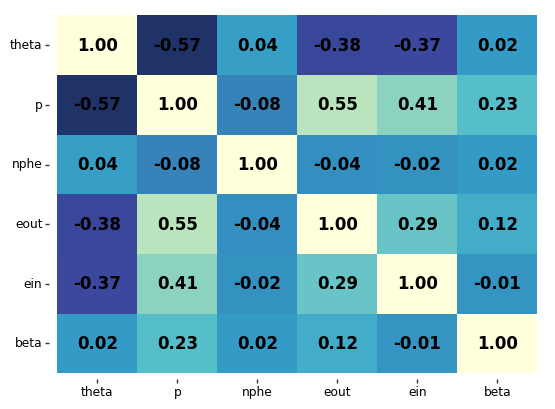

<ggplot: (8741302299793)>

In [7]:
cor_data['variable'] = pd.Categorical(cor_data['variable'], categories=["theta", "p", "nphe", "eout", "ein", "beta"], ordered=True)

corr_plot = ggplot(data=cor_data) \
          + geom_tile(mapping=aes(x="variable", y="variable2", fill="correlation"), alpha=0.9, show_legend=False) \
          + geom_text(aes(x="variable", y="variable2", label='correlation_label'), size=12, color='black', fontweight='bold') \
          + scale_fill_cmap("YlGnBu_r") \
          + labs(x='', y='', fill='') \
          + theme(text=element_text(color='black'), panel_grid_major=element_blank(), panel_grid_minor=element_blank(), panel_background=element_blank())
corr_plot

### Beta vs. Momentum

The Beta vs. Momentum plot shows the relationship between the $\beta$ measured by the ToF system and the momentum, p obtained from TPC. The visible bands are from $e^+$ (positron), $\pi^+$ (pion), $K^-$ (kaon), and p (proton).

In [ ]:
density_plot = ggplot(data=data) \
             + geom_bin2d(aes(x='p', y='beta'), bins=1000, show_legend=False) \
             + scale_fill_continuous("YlGnBu_r") \
             + labs(x='p (GeV/c)', y='β (radians)', fontweight='bold') \
             + coord_cartesian(ylim=(0.6, 1.05), xlim=(0.42, 4.5)) \
             + annotate("text", x = 0.4, y = 1.03, label = "e", color='yellow', size = 18, fontweight="bold") \
             + annotate("text", x = 0.8, y = 0.95, label = "π", color='yellow', size = 18, fontweight="bold") \
             + annotate("text", x = 1.3, y = 0.89, label = "K", color='yellow', size = 18, fontweight="bold") \
             + annotate("text", x = 1.65, y = 0.82, label = "p", color='yellow', size = 18, fontweight="bold") 
density_plot